In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Baseline Model

In [6]:
# First let's read in both of the dfs
df_2018 = pd.read_csv('PoliticalAds2018.csv')
df_2019 = pd.read_csv('PoliticalAds2019.csv')
# Now to concat them
data = pd.concat([df_2019, df_2018])
data.head()

,ADID,CreativeUrl,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,PayingAdvertiserName,...,Interests,OsType,Segments,LocationType,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),Targeting Geo - Postal Code,CreativeProperties
0,71ba5248cc7e9ef5c0ed69188f3e7f8b5f363595a6466f...,https://www.snap.com/political-ads/asset/0f662...,19566,3666639,2019/10/23 13:00:00Z,2019/11/16 07:59:52Z,Mediavest Spark,"375 Hudson Street Attention: Mailroom,New ...",NaN,"Recreational Equipment, Inc.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://ad.doubleclick.net/ddm/tr...
1,54f4ef6c68ed7b24cee50bfb4a25a606ee068a15dcd466...,https://www.snap.com/political-ads/asset/64bab...,78,24404,2019/09/04 22:42:26Z,NaN,Chong and Koster,"1640 Rhode Island Ave. NW, Suite 600,Washingto...",NaN,Voter Participation Center,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"42334,41052,40363,40110,41135,40473,41426,4074...",web_view_url:https://register2.rockthevote.com...
2,36cc255995c16a5dc8002e24c2405db22eca6ccfd00780...,https://www.snap.com/political-ads/asset/61a60...,16,4953,2019/09/19 20:43:21Z,NaN,UnRestrict Minnesota,US,NaN,UnRestrict Minnesota,...,"Green Living Enthusiasts,Hipsters & Trendsette...",NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://unrestrictmn.org/?utm_sou...
3,bd2e584d6bb99df611aaee731c8ee9335971c16115c119...,https://www.snap.com/political-ads/asset/8d722...,12,1694,2019/09/24 04:00:00Z,2019/10/16 03:59:59Z,ACRONYM,US,Register to Vote,ACRONYM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://www.peoplespowergrab.org/...
4,8ea74b355f848ecf46376d92dcb70675cfd93ca7990377...,https://www.snap.com/political-ads/asset/6bac9...,99,61299,2019/05/06 12:07:38Z,2019/05/26 15:29:12Z,Xaxis Light Reaction Austria,"Vordere Zollamtsstraße 13/7,Vienna,1030,AT",NaN,SPÖ,...,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First, we will clean the initial dataset.

In [7]:
def preprocess(df):
    # Create a copy to be safe
    df_copy = df.copy()
    
    # Before we can even verify if they merged correctly, we need to convert the start and end date to datetime objects
    df_copy['StartDate'] = pd.to_datetime(df_copy['StartDate'])
    # For End Date, we need to make the NaN values the time we downloaded the file, as it is subject to change if we run this at a later time
    download_date = "2019/11/04 18:31:00Z"
    df_copy['EndDate'] = pd.to_datetime(df_copy['EndDate']).fillna(pd.to_datetime(download_date))
    
    # Gender column targets all genders if NA
    df_copy['Gender'] = df_copy['Gender'].fillna('All')
    
    # AgeBracket column targets all ages if NA
    df_copy['AgeBracket'] = df_copy['AgeBracket'].fillna('All')
    
    # Interests has a weird concoction of strings, let's make it into a list
    df_copy['Interests'] = df_copy['Interests'].apply(
        lambda x: x.split(',') if (isinstance(x, str)) else 'All'
    )
    
    # So does Targeting Geo - Postal Code
    df_copy['Targeting Geo - Postal Code'] = df_copy['Targeting Geo - Postal Code'].apply(
        lambda x: x.split(',') if (isinstance(x, str)) else 'All'
    )
    
    # All other NaNs that are agnostic based on the readme.txt are filled here
    df_copy['RegionID'] = df_copy['RegionID'].fillna('All')
    df_copy['ElectoralDistrictID'] = df_copy['ElectoralDistrictID'].fillna('All')
    df_copy['LatLongRad'] = df_copy['LatLongRad'].fillna('All')
    df_copy['MetroID'] = df_copy['MetroID'].fillna('All')
    df_copy['OsType'] = df_copy['OsType'].fillna('All')
    df_copy['Language'] = df_copy['Language'].fillna('All')
    df_copy['AdvancedDemographics'] = df_copy['AdvancedDemographics'].fillna('All')
    df_copy['Targeting Connection Type'] = df_copy['Targeting Connection Type'].fillna('All')
    df_copy['Targeting Carrier (ISP)'] = df_copy['Targeting Carrier (ISP)'].fillna('All')
    
    # Modify Segments column so that 'Provided by Advertiser' == 1, na == 0
    df_copy["Segments"] = (
        df_copy["Segments"]
        .fillna(0)
        .replace('Provided by Advertiser', 1)
    )
    
    return df_copy

In [8]:
data = preprocess(data)
data.head()

,ADID,CreativeUrl,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,PayingAdvertiserName,...,Interests,OsType,Segments,LocationType,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),Targeting Geo - Postal Code,CreativeProperties
0,71ba5248cc7e9ef5c0ed69188f3e7f8b5f363595a6466f...,https://www.snap.com/political-ads/asset/0f662...,19566,3666639,2019-10-23 13:00:00+00:00,2019-11-16 07:59:52+00:00,Mediavest Spark,"375 Hudson Street Attention: Mailroom,New ...",NaN,"Recreational Equipment, Inc.",...,All,All,0,NaN,All,All,All,All,All,web_view_url:https://ad.doubleclick.net/ddm/tr...
1,54f4ef6c68ed7b24cee50bfb4a25a606ee068a15dcd466...,https://www.snap.com/political-ads/asset/64bab...,78,24404,2019-09-04 22:42:26+00:00,2019-11-04 18:31:00+00:00,Chong and Koster,"1640 Rhode Island Ave. NW, Suite 600,Washingto...",NaN,Voter Participation Center,...,All,All,0,NaN,All,All,All,All,"[42334, 41052, 40363, 40110, 41135, 40473, 414...",web_view_url:https://register2.rockthevote.com...
2,36cc255995c16a5dc8002e24c2405db22eca6ccfd00780...,https://www.snap.com/political-ads/asset/61a60...,16,4953,2019-09-19 20:43:21+00:00,2019-11-04 18:31:00+00:00,UnRestrict Minnesota,US,NaN,UnRestrict Minnesota,...,"[Green Living Enthusiasts, Hipsters & Trendset...",All,1,NaN,All,All,All,All,All,web_view_url:https://unrestrictmn.org/?utm_sou...
3,bd2e584d6bb99df611aaee731c8ee9335971c16115c119...,https://www.snap.com/political-ads/asset/8d722...,12,1694,2019-09-24 04:00:00+00:00,2019-10-16 03:59:59+00:00,ACRONYM,US,Register to Vote,ACRONYM,...,All,All,0,NaN,All,All,All,All,All,web_view_url:https://www.peoplespowergrab.org/...
4,8ea74b355f848ecf46376d92dcb70675cfd93ca7990377...,https://www.snap.com/political-ads/asset/6bac9...,99,61299,2019-05-06 12:07:38+00:00,2019-05-26 15:29:12+00:00,Xaxis Light Reaction Austria,"Vordere Zollamtsstraße 13/7,Vienna,1030,AT",NaN,SPÖ,...,All,All,1,NaN,All,All,All,All,All,NaN


Now for the baseline model! 

In [9]:
X_bs = data.drop(['Interests', 'AgeBracket', 'Targeting Geo - Postal Code', "StartDate", "EndDate", "CreativeProperties", "ADID", "CreativeUrl", "Impressions"], axis=1)
#X_bs = data.drop(["Impressions"], axis=1)
y_bs = data['Impressions']

First, we can to separate our categorical columns from our numerical columns. Then we can One Hot Encode the categoricals, imputing with null, and use StandardScaler for the numerical columns.

In [10]:
types = X_bs.dtypes
catcols_bs = types.loc[types == np.object].index
numcols_bs = types.loc[types != np.object].index

In [13]:
cats_bs = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

spend_bs = Pipeline([('std', StandardScaler())])

ct_bs = ColumnTransformer([
    ('catcols', cats_bs, catcols_bs),
    ('numcols', spend_bs, numcols_bs)
])

pl2 = Pipeline([('feats', ct_bs), ('reg', LinearRegression())])

In [15]:
X_tr_bs, X_ts_bs, y_tr_bs, y_ts_bs = train_test_split(X_bs, y_bs, test_size=0.30)
pl2.fit(X_tr_bs, y_tr_bs)
pred = pl2.predict(X_ts_bs)
np.sqrt(np.mean(pred - y_ts_bs)**2)

1.0173893485445947e+17

Now we can find the mean RMSE!

In [17]:
rmse_ls_bs = []
for i in range(50):
    X_tr_bs, X_ts_bs, y_tr_bs, y_ts_bs = train_test_split(X_bs, y_bs, test_size=0.30)
    pl2.fit(X_tr_bs, y_tr_bs)
    pred = pl2.predict(X_ts_bs)
    rmse = np.sqrt(np.mean(pred - y_ts_bs)**2)
    rmse_ls_bs.append(rmse)

In [18]:
np.mean(rmse_ls_bs)

8.838133907944307e+16

### Final Model

In [19]:
df = data.copy()

Now we're going to construct two features! The first feature utilizes BillingAddress to find out the country of origin, and the second utilizes StartDate and EndDate to find the duration the ad was shown.

In [20]:
df["OriginCountry"] = df["BillingAddress"].str.split(",").apply(lambda x: x[-1])
df["Duration"] = (df['EndDate'] - df["StartDate"]).apply(lambda x: x.days)

First we drop the columns that don't seem too useful. Interests, AgeBracket, Targeting Geo - Postal Code because of the structure that they're formatted in makes it complicated, BillingAddress, CreativeProperties, ADID, and CreativeUrl because they're simply nomitive, and StartDate/EndDate because we created a quantitive feature out of it (that is much more useful!).

In [21]:
X = df.drop(['Interests', 'AgeBracket', 'BillingAddress', 'Targeting Geo - Postal Code', "StartDate", "EndDate", "CreativeProperties", "ADID", "CreativeUrl", "Impressions"], axis=1)
y = df['Impressions']

Then,separate the columns by type -- int or object.

In [22]:
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

Now we're just going to try our original Pipeline again, with our new features! I used the same methods/transformers with our new features included as above, because sometimes it's better to keep it simple!

In [23]:
cats_draft = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

spend_draft = Pipeline([('std', StandardScaler())])

ct_draft = ColumnTransformer([
    ('catcols', cats_draft, catcols),
    ('numcols', spend_draft, numcols)
])

pl_draft = Pipeline([('feats', ct_draft), ('reg', LinearRegression())])

In [25]:
rmse_draft = []
for i in range(50):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.30)

    pl_draft.fit(X_tr, y_tr)
    #pl.score(X_ts, y_ts)

    preds = pl_draft.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_draft.append(rmse)

In [26]:
np.mean(rmse_draft)

6.93013844330038e+16

Let's see if the RandomForestRegressor model is better now, instead of LinearRegression.

In [31]:
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

spend = Pipeline([('std', StandardScaler())])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', spend, numcols)
])

pl = Pipeline([('feats', ct), ('reg', RandomForestRegressor(n_estimators=10))])

In [32]:
pl.fit(X_tr, y_tr)

Pipeline(memory=None,
         steps=[('feats',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('catcols',
                                                  Pipeline(memory=None,
                                                           steps=[('imp',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='NULL',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                                

Then, we calculated the RMSE again in a loop, and then found the average.

In [33]:
rmse_ls = []
for i in range(50):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.30)

    pl.fit(X_tr, y_tr)
    #pl.score(X_ts, y_ts)

    preds = pl.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_ls.append(rmse)

In [34]:
np.mean(rmse_ls)

83075.92048782045

Wow that's pretty good, and after a running this multiple times, RandomForestRegressor seems consistently better than LinearRegressor! Should we keep going?

RandomForestRegressor works with a nifty tool called GridSearchCV. Through this function, we can determine the best parameters for our RandomForestRegressor!

In [35]:
fit = pl.fit(X_tr, y_tr)
fit["reg"]

parameters = {'n_estimators': [10, 30], 'max_depth': [None, 1, 2, 4, 8], 'min_samples_split': [2, 3, 5]}
clf = GridSearchCV(fit["reg"], parameters, cv=5, verbose=1, refit=True)

In [36]:
clf.fit(X_tr[["Spend", "Duration"]], y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.1s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [None, 1, 2, 4, 8],
  

In [37]:
clf.best_params_

{'max_depth': 2, 'min_samples_split': 5, 'n_estimators': 30}

In [38]:
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

spend = Pipeline([('std', StandardScaler())])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', spend, numcols)
])

pl_gs = Pipeline([('feats', ct), ('reg', RandomForestRegressor(n_estimators=10, max_depth=4, min_samples_split= 3))])

In [39]:
rmse_ls_gs = []
for i in range(50):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.30)

    pl_gs.fit(X_tr, y_tr)
    #pl.score(X_ts, y_ts)

    preds = pl.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_ls_gs.append(rmse)

In [40]:
np.mean(rmse_ls_gs)

67653.49503095157

Wow! That got significantly better. We're pretty satisfied -- let's keep it.

### Fairness Evaluation

First, to evaluate our fairness, we computed the difference between the RMSEs for the groups targeted vs nontargeted (ads directed at all regions versus less).

In [41]:
from sklearn import metrics

In [42]:
imp = df.copy()

In [43]:
imp['Prediction'] = pl.predict(X)
imp["Targeted"] = imp["RegionID"] != "All"
imp.groupby('Targeted').Prediction.mean().to_frame()

,Prediction
Targeted,
False,722964.043115
True,321230.452675


In [44]:
imp["Diff"] = (imp["Impressions"]-imp["Prediction"])**2
obser = np.sqrt(imp.groupby('Targeted').Diff.mean()).diff().iloc[-1]

In [45]:
diff = []
for _ in range(100):
    s = (
        imp[['Targeted', 'Prediction', 'Impressions']]
        .assign(Targeted=imp.Targeted.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('Targeted')
        .apply(lambda x: np.sqrt(((x["Impressions"]-x["Prediction"])**2).mean()))
        .diff()
        .iloc[-1]
    )
    
    diff.append(s)

0.0


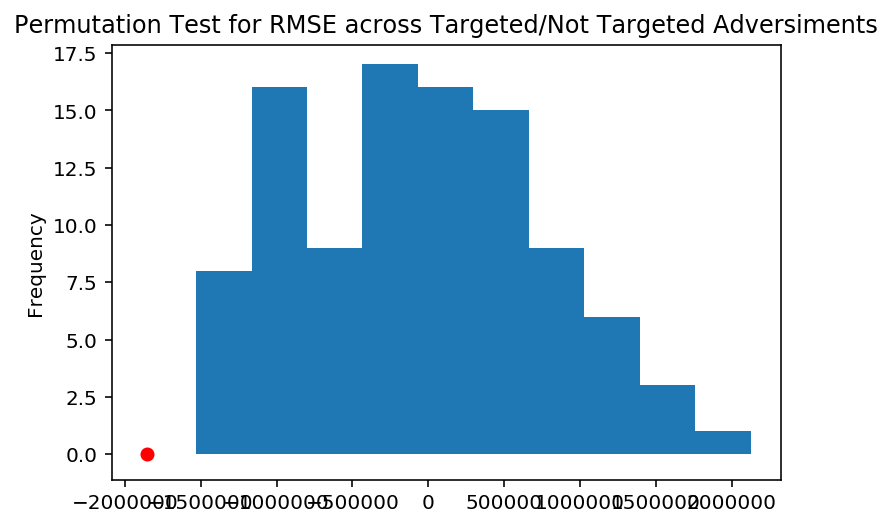

In [46]:
print(pd.Series(diff <= obser).mean())
pd.Series(diff).plot(kind='hist', title='Permutation Test for RMSE across Targeted/Not Targeted Adversiments')
plt.scatter(obser, 0, c='r');

Wow! It looks like targeted does get less impressions than non targeted ads, which is what was expected. 

Next, we can categorize impressions that are higher than the median to be viral (1) and those lower to be not viral (0).

In [47]:
parity = df.copy()
parity["Targeted"] = parity["RegionID"] != "All"
parity['Targeted'] = parity["Targeted"].replace({True:'targeted', False:'not targeted'})
parity['Prediction'] = pl.predict(X)

In [48]:
df["Impressions"].median()

69669.0

In [49]:
parity['Prediction'] = (parity['Prediction'] > 69669)
parity['Impressions'] = (parity['Impressions'] > 69669)
parity.groupby('Targeted').Prediction.mean().to_frame()

,Prediction
Targeted,
not targeted,0.531195
targeted,0.453266


In [50]:
(
    parity
    .groupby('Targeted')
    .apply(lambda x: metrics.accuracy_score(x.Impressions, x.Prediction))
    .rename('accuracy')
    .to_frame()
)

,accuracy
Targeted,
not targeted,0.969244
targeted,0.964824


Wow! This is better observation than expected!

In [51]:
obs = parity.groupby('Targeted').apply(lambda x: metrics.accuracy_score(x.Impressions, x.Prediction)).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        parity[['Targeted', 'Prediction', 'Impressions']]
        .assign(Targeted=parity.Targeted.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('Targeted')
        .apply(lambda x: metrics.accuracy_score(x.Impressions, x.Prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)

0.23


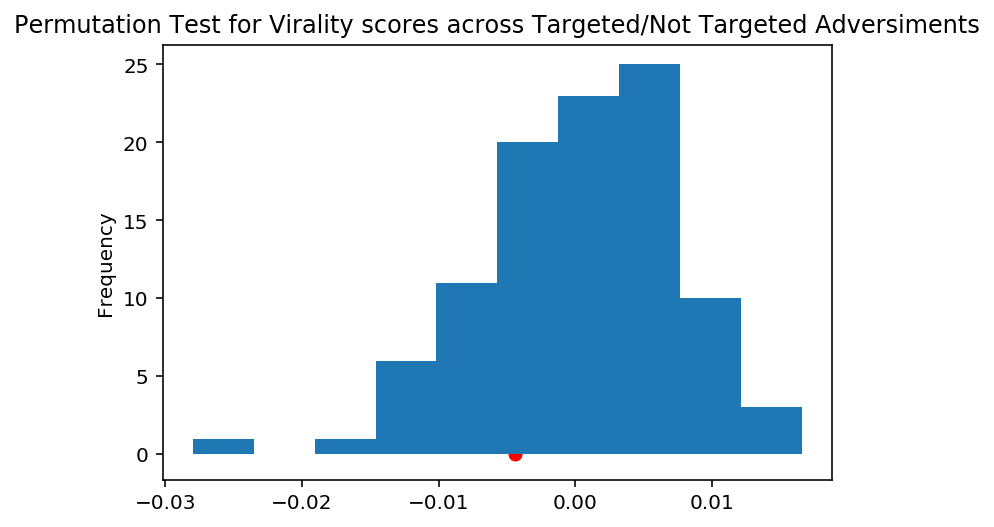

In [52]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for Virality scores across Targeted/Not Targeted Adversiments')
plt.scatter(obs, 0, c='r');